# Система распознавания дорожных знаков на датасете RTSD

## Обогащение датасета знаками из датасетов:
- German Traffic Sign Recognition Benchmark (GTSRB);
- BelgiumTS Dataset;
- Chinese Traffic Signs.

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone

if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

In [2]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.patches as patches

#from pycocotools.coco import COCO
#import fiftyone as fo
#import time
#import torch
#import torch.nn as nn
#import torchvision
#from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
#from torchvision.models import resnet152
#from sklearn import metrics
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

#import cv2

### Обучающий датасет RTSD

In [7]:
# Расшифровки ID категорий
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()

# Аннотация обучающей выборки RTSD
with open(os.path.join(dataset_path, 'train_anno.json'), 'r') as read_file:
    RTSD_train_anno = json.load(read_file)
read_file.close()
RTSD_train_anno.keys()

dict_keys(['images', 'annotations', 'categories'])

Визуализация исходного обучающего датасета

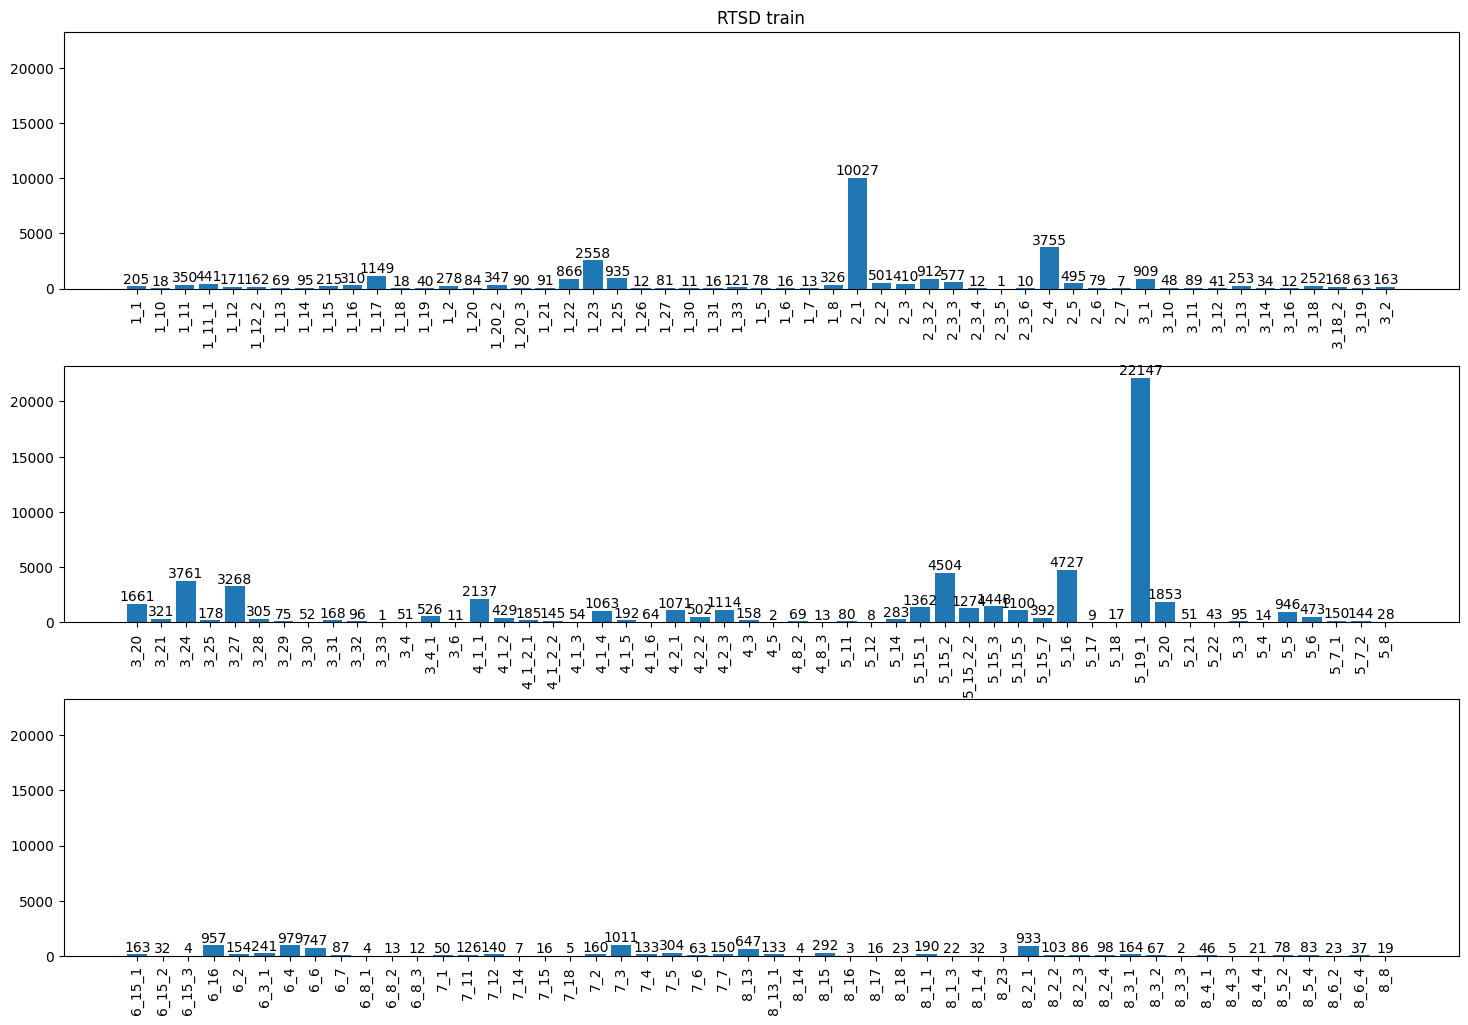

In [9]:
train_signs_distribution_df = pd.DataFrame(RTSD_train_anno.get('annotations'))
train_signs_distribution_df = train_signs_distribution_df.merge(pd.DataFrame([label_map]).T.reset_index().set_index(0),
                                                                left_on='category_id', right_index=True)
train_signs_distribution_df = train_signs_distribution_df['index'].value_counts().sort_index()
train_signs_distribution_df.name = 'count'

plot1 = train_signs_distribution_df[:53].copy()
plot2 = train_signs_distribution_df[53:105].copy()
plot3 = train_signs_distribution_df[105:].copy()
fig, ax = plt.subplots(nrows=3,ncols=1, sharey=True)
ax1, ax2, ax3 = ax.flatten()
bar1 = ax1.bar(plot1.index, plot1.values)
bar2 = ax2.bar(plot2.index, plot2.values)
bar3 = ax3.bar(plot3.index, plot3.values)
ax1.set_xticks(plot1.index, plot1.index, rotation=90)
ax2.set_xticks(plot2.index, plot2.index, rotation=90)
ax3.set_xticks(plot3.index, plot3.index, rotation=90)
ax1.bar_label(bar1)
ax2.bar_label(bar2)
ax3.bar_label(bar3)
ax1.set_title('RTSD train')
fig.set_size_inches(18,12)
plt.subplots_adjust(hspace=0.3)
plt.show()

Датасет German Traffic Sign Recognition Benchmark (GTSRB)

,count
5_19_1,22147
2_1,10027
5_16,4727
5_15_2,4504
3_24,3761
...,...
8_16,3
8_3_3,2
4_5,2
2_3_5,1


In [ ]:
Датасет German Traffic Sign Recognition Benchmark (GTSRB);
- BelgiumTS Dataset;
- Chinese Traffic Signs.